## Skin Cancer MNIST: HAM10000 disease Classification (Extended Project)

**Author: Antreas Kasiotis**

**Student Number: B8035526**

----

## **Project Overview**
The following work consists of an effort to develop an image classifier for dermatoscopic images of skin cancer. To tackle this project I will be working with the HAM10000 ("Human Against Machine with 10000 training images") dataset which is released as a training set for academic machine learning purposes and are publicly available through the ISIC archive. The dataset also consists of metadata for each of the images of the patients with information about their age, sex, the location of the disease on their body, the type of disease and the technical validation that confirmed the disease.

## **Data Exploration**


In [ ]:
# Importing libraries
import pandas as pd

Importing and inspecting the data

In [ ]:
# import the data of images
dataset_images_L = pd.read_csv("hmnist_28_28_L.csv")
print(dataset_images_L.head(3))
print("shape of images: ",dataset_images_L.shape)

   pixel0000  pixel0001  pixel0002  ...  pixel0782  pixel0783  label
0        169        171        170  ...        159        165      2
1         19         57        105  ...         18         18      2
2        155        163        161  ...        136        115      2

[3 rows x 785 columns]
shape of images:  (10015, 785)


As we can see the grescale image dataset holds information about 784 pixels. This is essentially the color values for a 28x28 pixel image. The last column in named lable and it indicated the type of skin cancer the patient has.

In [ ]:
# import the data of images
dataset_images_RGB = pd.read_csv("hmnist_28_28_RGB.csv")
print(dataset_images_RGB.head(3))
print("shape of images: ",dataset_images_RGB.shape)

   pixel0000  pixel0001  pixel0002  ...  pixel2350  pixel2351  label
0        192        153        193  ...        154        177      2
1         25         14         30  ...         14         27      2
2        192        138        153  ...        104        117      2

[3 rows x 2353 columns]
shape of images:  (10015, 2353)


As we can see the image dataset holds information about 2352 pixels. This is essentially the RGB values for a 28x28 pixel image bu becaus the data is stored for RGB colors, we also have three columns for each pixel since we have to store the RGB values for red, green and blue. Now let's inspect the metadata file.

In [ ]:
# import the metadata
dataset_meta = pd.read_csv("HAM10000_metadata.csv")
print(dataset_meta.head(3))
print("shape of metadata: ", dataset_meta.shape)

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
shape of metadata:  (10015, 7)


As expected the metadata dataset holds patient information for each image related to their disease and personal characteristics. Before commencing on with the implementation of the models I will be carrying out some exploratory data analysis for the metadata.

## **Exploratory data analysis**

#### **Introduction**
In this section I will be looking at the columns of the metadata dataset to better understand the characteristics of the disease and the patients.

In [ ]:
# importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

#### **Disease class frequencies**


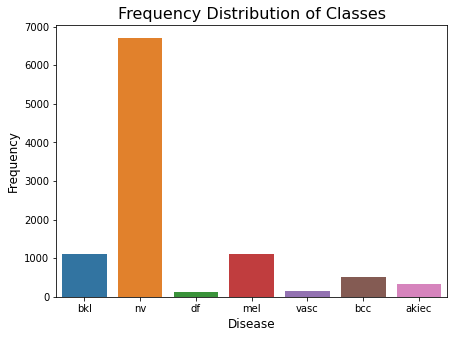

In [ ]:
# Plotting the disease class frequencies
bar, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x = 'dx', data = dataset_meta)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)
plt.show()

In the plot above we can see that the disease with class "nv" (melanocytic nevi) in the most frequent one, with just less than 7000 of the 10015 images being melanocytic nevi. 

#### **Age groups with the disease**


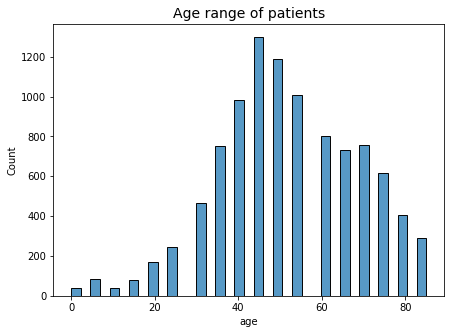

In [ ]:
# Plotting the frequencies of each age of those with the disease
bar, ax = plt.subplots(figsize=(7, 5))
sns.histplot(dataset_meta['age'])
plt.title('Age range of patients', size=14)
plt.show()

The plot above clearly indicates the are group that is mostly affected by skin cancer, which is that of ages between 40 and 48. 

#### **Localization of the disease on the body**


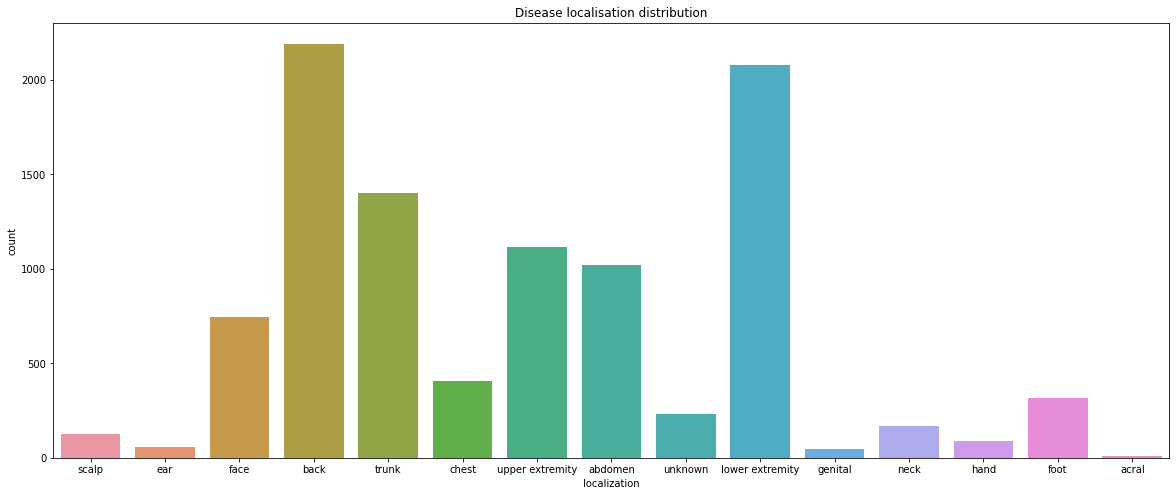

In [ ]:
# Plotting the distribution of the localization of the disease
disease_location = dataset_meta['localization'].value_counts()
plt.figure(figsize=(20, 8))
sns.countplot(x='localization', data=dataset_meta)
plt.title('Disease localisation distribution')
plt.show()

By fat the most frequent locations of the body that skin cancer appeared was the back and the lower extermity, followed by the trunk, upper extermity and the abdomen.

#### **The genders of the patients**


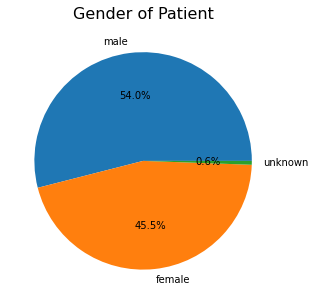

In [ ]:
# Plotting the gender frequencies of the patients
bar, ax = plt.subplots(figsize=(5, 5))
plt.pie(dataset_meta['sex'].value_counts(),
        labels = dataset_meta['sex'].value_counts().index, 
        autopct="%.1f%%")
plt.title('Gender of Patient', size=16)
plt.show()

In terms of the gender of patients that are most affected I have found that males are slightly more affected. 

## **Implemention of the Classifiers**

### **Introduction**

At this phase of the project I will be using three different methods to build my skin cancer image classifiers. In this section will also be showing the various types of data pre-processing that was required to implement each classifier. In total I will be buiding three classifiers, the cnn (convolutional neural network), the lstm (Long short-term memory RNN), and the svm (Support vector machine). For each type of classifier I will create two implementation, one of greyscale images and one for coloured ones. This will be done so that we can also observe the difference between the classifiers according to the data that they use. 

### **CNN (convolutional neural network)**

#### **Libraries and constants**

In [1]:
# Importing required libraries
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn.metrics as metrics
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D


In [2]:
# defining the number of classes
num_classes = 7
# defining the batch size and epochs for the model
batch_size = 128
epochs = 10

# defining the number of rows and columns representing the pixels
img_rows = 28
img_cols = 28

#### **Greyscale Images**

Setting up and building a cnn model for the greyscale images. To pre-process my data, I separated my image dataset into predictor and response variables. I then oversample these variables to overcome the class imbalance we saw earlier in the EDA. Furthermore, I reshape and normalize my images and I also encode my labels to one-hot vectors so that they can be fitted to the model. 

In [ ]:
# removing the 'label' column from the data frame so I only keep the image data
images = dataset_images_L.drop(['label'], axis=1)
# keeping only the label column
labels = dataset_images_L['label']

# Oversampling to overcome class imbalance
oversample = RandomOverSampler()
images, labels = oversample.fit_resample(images, labels)

# resizing the images and parsing them into an array
images = np.array(images)
images = images.reshape(-1, 28, 28, 1)
print('Shape of images: ', images.shape)

# Normalizing the images.
images = (images-np.mean(images))/np.std(images)

# Splitting my predictive and response data into training and testing sets with an 80:20 ratio
# while the state is set to a constant so that the splitting can be done reproducibly
x_train, x_test, y_train, y_test = train_test_split(images, labels, random_state=1, test_size=0.20)

# encoding my labels to one-hot vectors
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

start = time.time()

# Model building
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
callback = tf.keras.callbacks.ModelCheckpoint(filepath='trained-models/cnn-best-model-L.h5', monitor='val_acc', mode='max', verbose=1)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

# Fitting the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[callback])
stop = time.time()

Shape of images:  (46935, 28, 28, 1)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 5, 5, 64)          0         
                                                                 
 flatten_3 (Flatt

The model was successfuly built and fitted. Now let's investigate how well this model performed.

Summary: Loss over the test dataset: 0.35, Accuracy: 0.88
Time to build and train the model is :  4.539390929539999  minutes


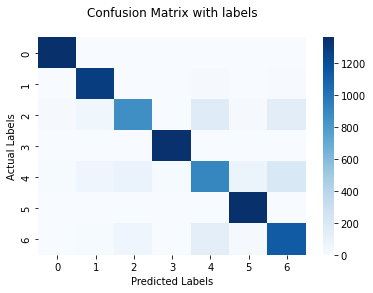

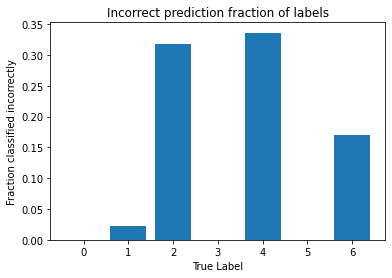

In [ ]:
# Evaluating the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (score[0], score[1]))

#printing the time it took to build and train the model
print("Time to build and train the model is : ",(stop - start)/60, " minutes")

# Setting up the variables require to created a confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis =1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred_classes )

# plotting the confusion matrix for the model label prediction
ax = sns.heatmap(confusion_matrix, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
plt.show()

# plotting the incorrect prediction fraction of each class label
label_frac_error = 1 - np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.title('Incorrect prediction fraction of labels')
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.show()

The cnn on the greyscale images had a loss over the dataset of 35% and an accuaracy of 88%. The total time it took to build and fit this model was 4.539 minutes. From the confusion matrix we can see that most labels got correctly predicted with just a few exceptions. The second plot shows us the fraction of incorrectly label classes.

In the case of label 1, it was wrongfuly labeled 2% of the times, label 2, was wrongfuly labeled 32% of the times, label 4, was wrongfuly labeled 34% of the times and lastly label 6, was wrongfuly labeled 17% of the times. On the other hand, labels 0, 3 and 5 were labeled correctly 100% of the time.

#### **RGB Images**

Setting up and building a cnn model for the RGB images. To pre-process my data, I separate my image dataset into predictor and response variables. I then oversample these variables to overcome the class imbalance we saw earlier in the EDA. Furthermore, I reshape and normalize my images and I also encode my labels to one-hot vectors so that they can be fitted to the model. 

In [ ]:
# removing the 'label' column from the data frame so I only keep the image data
images = dataset_images_RGB.drop(['label'], axis=1)
# keeping only the label column
labels = dataset_images_RGB['label']

# Oversampling to overcome class imbalance
oversample = RandomOverSampler()
images, labels = oversample.fit_resample(images, labels)

# resizing the images and parsing them into an array
images = np.array(images)
images = images.reshape(-1, 28, 28, 3)
print('Shape of images: ', images.shape)

# Normalizing the images.
images = (images - np.mean(images)) / np.std(images)

# Splitting my predictive and response data into training and testing sets with an 80:20 ratio
# while the state is set to a constant so that the splitting can be done reproducibly
x_train, x_test, y_train, y_test = train_test_split(images, labels, random_state=1, test_size=0.20)

# encoding my labels to one-hot vectors
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

start = time.time()

# Model building
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath='trained-models/cnn-best-model-RGB.h5', monitor='val_acc', mode='max', verbose=1)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

# Fitting the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[callback])

stop = time.time()

Shape of images:  (46935, 28, 28, 3)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 5, 5, 64)          0         
                                                                 
 flatten_2 (Flatt

The model was successfuly built and fitted. Now let's investigate how well this model performed.

Summary: Loss over the test dataset: 0.24, Accuracy: 0.92
Time to build and train the model is :  5.378949646155039  minutes


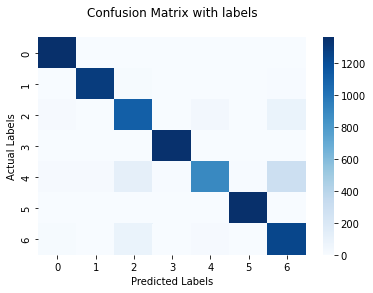

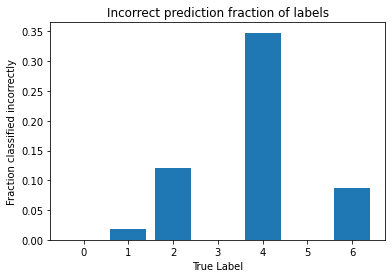

In [ ]:
# Evaluating the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (score[0], score[1]))

print("Time to build and train the model is : ",(stop - start)/60, " minutes")

# Setting up the variables require to created a confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis =1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred_classes )

# plotting the confusion matrix for the model label prediction
ax = sns.heatmap(confusion_matrix, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
plt.show()

# plotting the incorrect prediction fraction of each class label
label_frac_error = 1 - np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.title('Incorrect prediction fraction of labels')
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.show()

The cnn on the RGB images had a loss over the dataset of 23% and an accuaracy of 92%. The total time it took to build and fit this model was 4.385 minutes. From the confusion matrix we can see that most labels got correctly predicted. 

The second plot shows us the fraction of incorrectly label classes. In the case of label 1, it was wrongfuly labeled 2% of the times, label 2, was wrongfuly labeled 12% of the times, label 4, was wrongfuly labeled 35% of the times and lastly label 6, was wrongfuly labeled 8% of the times. On the other hand, labels 0, 3 and 5 were again labeled correctly 100% of the time. 

#### **Comparison**
When comparing to the cnn for RGB images against the cnn for greyscale images we observe that in the RGB model there was a significant increase in performance in both the overall accuracy of the model and the incorrect classification of all labels independently, except for label 4 as well as significant decrease in loss over the dataset. In terms of runtime we also see that the RGB cnn model was quicker too which is really surpizing considering that it had to deal a lot more data.

### **LSTM (Long short-term memory RNN)**

#### **Libraries and constants**

In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
from keras.datasets import mnist
from keras.utils import np_utils
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [ ]:
# Hyper parameters
batch_size = 128
nb_epoch = 10

# Parameters for MNIST dataset
img_rows, img_cols = 28, 28
num_classes = 7

# Parameters for LSTM network
nb_lstm = 64
nb_time_steps = img_rows
dim_input_vector = img_cols

#### **Greyscale Images**

Setting up and building an lstm model for the greyscale images. To pre-process my data, I separated my image dataset into predictor and response variables. I then oversample these variables to overcome the class imbalance we saw earlier in the EDA. Furthermore, I reshape and normalize my images and I also encode my labels to one-hot vectors so that they can be fitted to the model. 

In [ ]:

# removing the 'label' column from the data frame so I only keep the image data
images = dataset_images_L.drop(['label'], axis=1)
# keeping only the label column
labels = dataset_images_L['label']

# Oversampling to overcome class imbalance
oversample = RandomOverSampler()
images, labels = oversample.fit_resample(images, labels)

# resizing the images and parsing them into an array
images = np.array(images)
images = images.reshape(-1, 28, 28)
print('Shape of images: ', images.shape)

# Normalizing the images.
images = (images - np.mean(images)) / np.std(images)

# Splitting my predictive and response data into training and testing sets with an 80:20 ratio
# while the state is set to a constant so that the splitting can be done reproducibly
x_train, x_test, y_train, y_test = train_test_split(images, labels, random_state=1, test_size=0.20)

# encoding my labels to one-hot vectors
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

print('X_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

start = time.time()

# Build LSTM network
model = Sequential()
model.add(LSTM(nb_lstm, input_shape=(nb_time_steps, dim_input_vector), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(nb_lstm, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath='trained-models/lstm-best-model-L.h5', monitor='val_acc', mode='max', verbose=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, callbacks=[callback], validation_split = 0.2)

stop = time.time()

Shape of images:  (46935, 28, 28)
X_train shape: (37548, 28, 28)
37548 train samples
9387 test samples
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 28, 64)            23808     
                                                                 
 dropout_10 (Dropout)        (None, 28, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 7)                 455       
                                                                 
Total params: 57,287
Trainable params: 57,287
Non-trainable params: 0
_____________

Summary: Loss over the test dataset: 0.52, Accuracy: 0.80
Time to build and train the model is :  3.4435091892878216  minutes


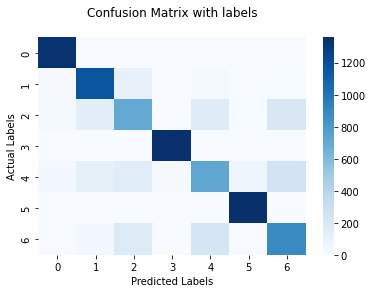

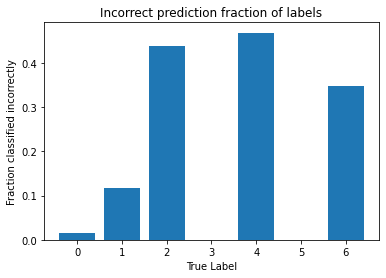

In [ ]:
# Evaluating the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (score[0], score[1]))

print("Time to build and train the model is : ",(stop - start)/60, " minutes")

# Setting up the variables require to created a confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis =1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred_classes )

# plotting the confusion matrix for the model label prediction
ax = sns.heatmap(confusion_matrix, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
plt.show()

# plotting the incorrect prediction fraction of each class label
label_frac_error = 1 - np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.title('Incorrect prediction fraction of labels')
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.show()

The LSTM on the greyscale images had a loss over the dataset of 52% and an accuaracy of 80%. The total time it took to build and fit this model was 3.444 minutes. From the confusion matrix we can see that most labels got correctly predicted. 

The second plot shows us the fraction of incorrectly label classes. In the case of label 0, it was wrongfuly labeled 2% of the times, label 1, was wrongfuly labeled 12% of the times, label 2, was wrongfuly labeled 45% of the times, label 4, was wrongfuly labeled 48% of the times, and lastly label 6 was wrongfuly labeled 35% of the times. On the other hand, labels 3 and 5 were labeled correctly 100% of the time. 

#### **RGB Images**

Setting up and building an lstm model for the RGB images. To pre-process my data, I separated my image dataset into predictor and response variables. I then oversample these variables to overcome the class imbalance we saw earlier in the EDA. Furthermore, I reshape and normalize my images and I also encode my labels to one-hot vectors so that they can be fitted to the model. 

In [ ]:

# removing the 'label' column from the data frame so I only keep the image data
images = dataset_images_RGB.drop(['label'], axis=1)
# keeping only the label column
labels = dataset_images_RGB['label']

# Oversampling to overcome class imbalance
oversample = RandomOverSampler()
images, labels = oversample.fit_resample(images, labels)

# Parsing the images into an array and resizing them from 4d arrays to 3d arrays
images = np.array(images)
images = images.reshape(-1, 28, 84)

# Normalizing the images.
images = (images - np.mean(images)) / np.std(images)

# Splitting my predictive and response data into training and testing sets with an 80:20 ratio
# while the state is set to a constant so that the splitting can be done reproducibly
x_train, x_test, y_train, y_test = train_test_split(images, labels, random_state=1, test_size=0.20)

# Chacking the structure of my test and train sets
print('X_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# encoding my labels to one-hot vectors
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

start = time.time()

# Building LSTM network
model = Sequential()
model.add(LSTM(nb_lstm, input_shape=(nb_time_steps, 84), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(nb_lstm, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath='trained-models/lstm-best-model-RGB.h5', monitor='val_acc', mode='max', verbose=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, callbacks=[callback], validation_split = 0.2)

stop = time.time()

X_train shape: (37548, 28, 84)
37548 train samples
9387 test samples
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 28, 64)            38144     
                                                                 
 dropout_8 (Dropout)         (None, 28, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 7)                 455       
                                                                 
Total params: 71,623
Trainable params: 71,623
Non-trainable params: 0
_______________________________________________

Summary: Loss over the test dataset: 0.34, Accuracy: 0.88
Time to build and train the model is :  3.6314243197441103  minutes


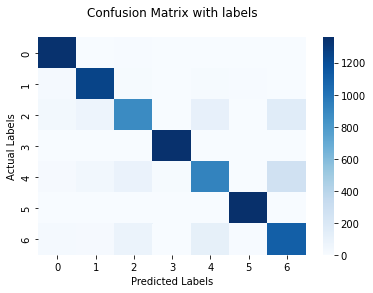

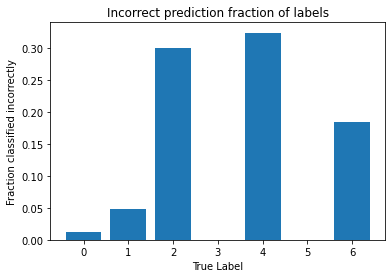

In [ ]:
# Evaluating the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (score[0], score[1]))

print("Time to build and train the model is : ",(stop - start)/60, " minutes")

# Setting up the variables require to created a confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis =1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred_classes )

# plotting the confusion matrix for the model label prediction
ax = sns.heatmap(confusion_matrix, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
plt.show()

# plotting the incorrect prediction fraction of each class label
label_frac_error = 1 - np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.title('Incorrect prediction fraction of labels')
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.show()

The LSTM on the RGB images had a loss over the dataset of 34% and an accuaracy of 88%. The total time it took to build and fit this model was 3.631 minutes. From the confusion matrix we can see that most labels got correctly predicted.

The second plot shows us the fraction of incorrectly label classes. In the case of label 0, it was wrongfuly labeled 2% of the times, label 1, was wrongfuly labeled 5% of the times, label 2, was wrongfuly labeled 30% of the times, label 4, was wrongfuly labeled 35% of the times, and lastly label 6 was wrongfuly labeled 18% of the times. On the other hand, labels 3 and 5 were labeled correctly 100% of the time.

#### **Comparison**
When comparing to the lstm for RGB images against the lstm for greyscale images we observe that in the RGB model there was quite a significant increase in performance in both the overall accuracy of the model and the incorrect classification of all labels independently, except for label 4. There was also a noticable decrease in loss of the dataset in the RGB model. However, in terms of runtime we see that the greyscale lstm model was quicker.

### **SVM (Support vector machine)**

#### **Libraries and constants**

In [ ]:
import pandas as pd
import numpy as np
import keras
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
# Parameters for MNIST dataset
img_rows, img_cols = 28, 28
num_classes = 7

#### **Greyscale Images**

Setting up and building an SVM model for the greyscale images. To pre-process my data, I separated my image dataset into predictor and response variables. I oversampled my data to overcome the class imbalance we saw in the EDA. I reformatted, reshaped and normalized my images so that they can be fitted to the model. To make fitting the model possible I have taken a sample of 15000 images from my oversampled data since it would be very time-consuming to use all 46000 images produced by the oversampling. 

In [ ]:
# removing the 'label' column from the data frame so I only keep the image data
images = dataset_images_L.drop(['label'], axis=1)
# keeping only the label column
labels = dataset_images_L['label']

# Oversampling to overcome class imbalance
oversample = RandomOverSampler()
images, labels = oversample.fit_resample(images, labels)
print(images.shape)

# Keeping a smaller sample so that the cross-validation doesn't take too long
images = images.sample(n=15000, random_state=1)
labels = labels.sample(n=15000, random_state=1)
print(images.shape)

# restructuring the images to be fitted in the model
images = images.astype('float32')

# Normalizing the images.
images = (images - np.mean(images)) / np.std(images)

# Splitting my predictive and response data into training and testing sets with an 80:20 ratio
# while the state is set to a constant so that the splitting can be done reproducibly
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, random_state=1, test_size=0.20)

# Performing LDA for dimentionality reduction
lda = LDA()
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)

#starting timer
start = time.time()

# Finding the best parameters by cross-validation
parameters = [{'kernel': ['rbf'],
               'gamma': [0.01, 0.1, 0.5],
               'C': [10, 100, 1000]}]
print("# Tuning hyper-parameters")
clf = GridSearchCV(SVC(), parameters, cv=5)
clf.fit(x_train, y_train)
print('best parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

#stoping timer
stop = time.time()

(46935, 784)
(15000, 784)
# Tuning hyper-parameters
best parameters:
{'C': 100, 'gamma': 0.5, 'kernel': 'rbf'}
-------------------------------------
0.759 (+/-0.004) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.794 (+/-0.006) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.863 (+/-0.006) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.768 (+/-0.013) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.816 (+/-0.007) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.872 (+/-0.007) for {'C': 100, 'gamma': 0.5, 'kernel': 'rbf'}
0.775 (+/-0.011) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.839 (+/-0.005) for {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
0.871 (+/-0.010) for {'C': 1000, 'gamma': 0.5, 'kernel': 'rbf'}


Using the found optimal parameters of 'C': 100 and 'gamma': 0.5 to fit the svm

The accuracy score is:  0.875
Time to build and train the model is :  4.872865168253581  minutes


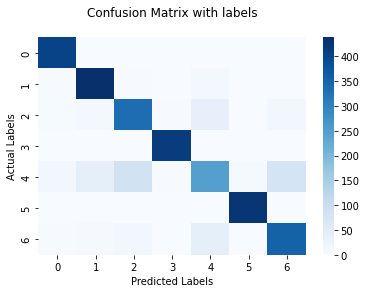

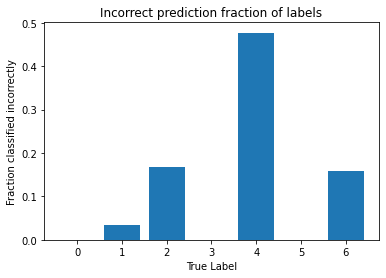

In [ ]:
# setting the optimal parameters that were found
optimal_C = 100
optimal_gamma = 0.5

# Fitting the model
svc = SVC(kernel="rbf", gamma=optimal_gamma, C=optimal_C)
svc.fit(x_train, y_train)

pred = svc.predict(x_test)

# printing the accuracy of the SVM model
print("The accuracy score is: ", accuracy_score(y_test, pred))

print("Time to build and train the model is : ",(stop - start)/60, " minutes")

# Setting up the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=pred )

# plotting the confusion matrix for the model label prediction
ax = sns.heatmap(confusion_matrix, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
plt.show()

# plotting the incorrect prediction fraction of each class label
label_frac_error = 1 - np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.title('Incorrect prediction fraction of labels')
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.show()

The SVM on the greyscale images had an accuaracy of 87.5%. The total time it took to build and fit this model was 4.873 minutes. From the confusion matrix we can see that most labels got correctly predicted with the exception of label 4 which seem to have quite a few wrongful prediction. 

The second plot shows us the fraction of incorrectly label classes. In the case of label 1, it was wrongfuly labeled 4% of the times, label 2, was wrongfuly labeled 17% of the times, label 4, was wrongfuly labeled 48% of the times, and lastly label 6 was wrongfuly labeled 16% of the times. On the other hand, labels 0, 3 and 5 were labeled correctly 100% of the time. 

#### **RGB Images**

Setting up and building an SVM model for the RGB images. To pre-process my data, I separated my image dataset into predictor and response variables. I oversampled my data to overcome the class imbalance we saw in the EDA. I reformatted, reshaped and normalized my images so that they can be fitted to the model. To make fitting the model possible I have taken a sample of 15000 images from my oversampled data since it would be very time-consuming to use all 46000 images produced by the oversampling. 

In [ ]:
# removing the 'label' column from the data frame so I only keep the image data
images = dataset_images_RGB.drop(['label'], axis=1)
# keeping only the label column
labels = dataset_images_RGB['label']

# Oversampling to overcome class imbalance
oversample = RandomOverSampler()
images, labels = oversample.fit_resample(images, labels)
print(images.shape)

# Keeping a smaller sample so that the cross-validation doesn't take too long
images = images.sample(n=15000, random_state=1)
labels = labels.sample(n=15000, random_state=1)
print(images.shape)

# restructuring the images to be fitted in the model
images = images.astype('float32')

# Normalizing the images.
images = (images - np.mean(images)) / np.std(images)

# Splitting my predictive and response data into training and testing sets with an 80:20 ratio
# while the state is set to a constant so that the splitting can be done reproducibly
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, random_state=1, test_size=0.20)

# Performing LDA for dimentionality reduction
lda = LDA()
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)

start = time.time()

# Finding the best parameters by cross-validation
parameters = [{'kernel': ['rbf'],
               'gamma': [0.01, 0.1, 0.5],
               'C': [10, 100, 1000]}]
print("# Tuning hyper-parameters")
clf = GridSearchCV(SVC(), parameters, cv=num_classes)
clf.fit(x_train, y_train)

print('best parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

stop = time.time()

(46935, 2352)
(15000, 2352)
# Tuning hyper-parameters
best parameters:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
-------------------------------------
0.958 (+/-0.006) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.954 (+/-0.010) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.946 (+/-0.006) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.958 (+/-0.007) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.947 (+/-0.012) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.946 (+/-0.006) for {'C': 100, 'gamma': 0.5, 'kernel': 'rbf'}
0.954 (+/-0.008) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.945 (+/-0.008) for {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
0.946 (+/-0.006) for {'C': 1000, 'gamma': 0.5, 'kernel': 'rbf'}


Using the found optimal parameters of 'C': 10, 'gamma': 0.01 to fit the svm

The accuracy score is:  0.878
Time to build and train the model is :  1.9702072739601135  minutes


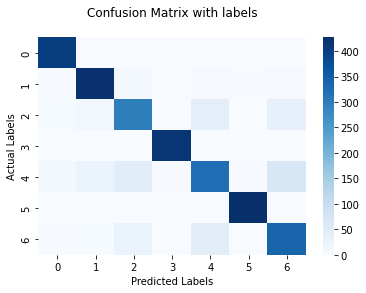

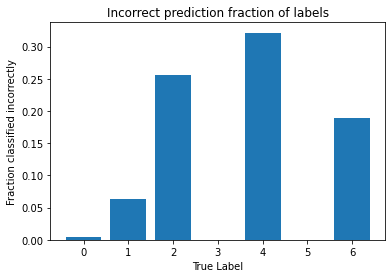

In [ ]:
# setting the optimal parameters that were found
optimal_C = 10
optimal_gamma = 0.01

# Fitting the model
svc = SVC(kernel="rbf", gamma=optimal_gamma, C=optimal_C)
svc.fit(x_train, y_train)

pred = svc.predict(x_test)

# printing the accuracy of the model
print("The accuracy score is: ", accuracy_score(y_test, pred))

print("Time to build and train the model is : ",(stop - start)/60, " minutes")

# Setting up the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=pred )

# plotting the confusion matrix for the model label prediction
ax = sns.heatmap(confusion_matrix, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
plt.show()

# plotting the incorrect prediction fraction of each class label
label_frac_error = 1 - np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.title('Incorrect prediction fraction of labels')
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.show()

The SVM on the greyscale images had an accuaracy of 87.8%. The total time it took to build and fit this model was 1.970 minutes. From the confusion matrix we can see that most labels got correctly predicted with the exception of a couple of labels that were incorrectly labeled a few times. 

The second plot shows us the fraction of incorrectly label classes. In the case of label 0, it was wrongfuly labeled 1% of the times, label 1, was wrongfuly labeled 7% of the times, label 2, was wrongfuly labeled 25% of the times, label 4 was incorrectly labeled 35% of the times, and lastly label 6 was wrongfuly labeled 18% of the times. On the other hand, labels 3 and 5 were labeled correctly 100% of the time. 

#### **Comparison**
When comparing to the SVM for RGB images against the SVM for greyscale images we observe that in the RGB model there was no particular increase in the overall accuracy of the model. In the case of the incorrect prediction of labels, the RGB model was more accurate in classifying label 4 but not the rest. The most notable difference among the two models however was the runtime, with the RGB model suprizingly being more two times faster while dealing with more image data.

### **Conclusion**

Having developed and fitted all three models for both categories of image data (greyscale and RGB) I was able to then evaluate them across a range of metrics and compare them. To fairly compare them all I will be displaying all of the metrics that were recorded below.

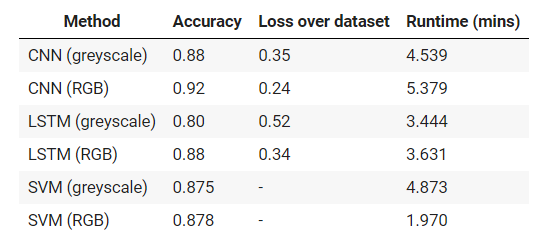

Additionally, most models had similar issues when it came to misclassifications of labels. The models mislabeled the classes of 4, 2 and 6, ranked from highest to lower misclassification percentage. However, it is worth noting that this percentage was lower in the models that dealt with RGB images. This leads me to the conclusion that RGB images are helpful in minimizing misclassifications and as we can see from the table above, maximizing the model's accuracy. In terms of runtime, the models with RGB images run equally as fast or even faster that then models with the greyscale images, with the exception of the CNN model where it was 0.8 minutes slower.

The overall best performing model was found to be CNN that fitted the RGB images. It had the best accuracy and loss over data out of all the other models. Its missclassifications were marginalized and its runtime although not great, it was reasonable.


